In [1]:
#!sudo pip3 install pandas
#!sudo pip3 install sklearn
#!sudo pip3 install graphviz
#!sudo pip3 install seaborn

In [2]:
import pandas as pd

# I. Traitement des données

### 1. Importation du dataset contenant les données débloatées 
(Plusieurs colonnes normalisées (caller_id, opened_by, sys_created_by, sys_updated_by, location, category, subcategory, u_symptom, cmdb_ci, assignement_group, assigned_to, problem_id, rfc, vendor, closed_code, resolved_by ne contiennent plus que des valeurs numériques, sans perte d'information). Les "?" ont été remplacés par des cases vides. 
De plus, les variables de type object ou string ont été converties en float ou int, suivant le cas.

In [3]:
#La colonne "caused_by" a été supprimée car vide
dataset = pd.read_csv("incident_event_log_debloated.csv", sep=',', encoding='UTF-8')
dataset

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,2403.0,8.0,29/2/2016 01:16,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,2403.0,397.0,29/2/2016 04:40,...,True,False,Do Not Notify,NaN,NaN,NaN,5.0,81.0,1/3/2016 09:52,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,116.0,12.0,16/2/2017 09:09,...,False,True,Do Not Notify,NaN,NaN,NaN,9.0,9.0,16/2/2017 09:53,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,116.0,12.0,16/2/2017 14:17,...,False,False,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,116.0,12.0,16/2/2017 14:17,...,False,False,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,116.0,12.0,16/2/2017 14:17,...,False,True,Do Not Notify,NaN,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38


In [4]:
dataset.dtypes

number                      object
incident_state              object
active                        bool
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                      bool
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                object
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                      object
urgency                     object
priority                    object
assignment_group           float64
assigned_to                float64
knowledge                     bool
u_priority_confirmation       bool
notify                      object
problem_id          

### 2. Conversion des types de données erronés
On va supprimer certaines colonnes qui sont inutiles pour notre régression, comme l'ID de l'incident et le RFC.
Pandas a également mal interprété le type de données de certaines colonnes, on applique donc une correction.

In [5]:
dataset = dataset.drop(columns="rfc")
dataset.active = dataset.active.astype(int)
dataset.made_sla = dataset.made_sla.astype(int)
print(dataset.incident_state.value_counts())
incident_state_dico = {"New":0, "Resolved":1, "Closed":2, "Active":3, "Awaiting User Info":4, "Awaiting Vendor":5, "Awaiting Problem":6, "Awaiting Evidence":7, "-100":8}

Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: incident_state, dtype: int64


In [6]:
#dataset.replace({"incident_state": incident_state_dico})
dataset.incident_state = dataset.incident_state.map(incident_state_dico)

In [7]:
print(dataset.contact_type.value_counts())
contact_type_dico = {"Phone":0, "Self service":1, "Email":2, "IVR":3, "Direct opening":4}
dataset.contact_type = dataset.contact_type.map(contact_type_dico)
dataset.contact_type

Phone             140462
Self service         995
Email                220
IVR                   18
Direct opening        17
Name: contact_type, dtype: int64


0         0
1         0
2         0
3         0
4         0
         ..
141707    2
141708    2
141709    2
141710    2
141711    2
Name: contact_type, Length: 141712, dtype: int64

In [8]:
print(dataset.impact.value_counts())
impact_dico = {"2 - Medium":2, "3 - Low":3, "1 - High":1}
dataset.impact = dataset.impact.map(impact_dico)
dataset.urgency = dataset.urgency.map(impact_dico)

2 - Medium    134335
3 - Low         3886
1 - High        3491
Name: impact, dtype: int64


In [9]:
print(dataset.priority.value_counts())
priority_dico = {"3 - Moderate":3, "4 - Low":4, "2 - High":2, "1 - Critical":1}
dataset.priority = dataset.priority.map(priority_dico)

3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Critical      2258
Name: priority, dtype: int64


In [10]:
dataset.knowledge = dataset.knowledge.astype(int)
dataset.u_priority_confirmation = dataset.u_priority_confirmation.astype(int)

In [11]:
print(dataset.notify.value_counts())
notify_dico = {"Do Not Notify":0, "Send Email":1}
dataset.notify = dataset.notify.map(notify_dico)

Do Not Notify    141593
Send Email          119
Name: notify, dtype: int64


In [12]:
print(dataset.vendor.value_counts())
vendor_dico = {"8s":0, "Vendor 1":1, "Vendor 2":2, "Vendor 3":3}
dataset.vendor = dataset.vendor.map(vendor_dico)

8s          167
Vendor 1     69
Vendor 3      6
Vendor 2      2
Name: vendor, dtype: int64


In [13]:
dataset.dtypes

number                      object
incident_state               int64
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                 int64
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                       int64
urgency                      int64
priority                     int64
assignment_group           float64
assigned_to                float64
knowledge                    int64
u_priority_confirmation      int64
notify                       int64
problem_id          

In [14]:
dataset.shape

(141712, 34)

### 3. On cherche le temps de résolution pour chaque ligne
Pour chaque ligne, on calcule la différence de temps entre la résolution et l'ouverture de l'incident. Ces informations sont rangées dans une liste de la même longueur que le dataset.

In [15]:
Y_list = list()
def resolved_time(row):    
    cols = ['opened_at','closed_at']
    #cols = ['opened_at','resolved_at']
    opened_at = pd.to_datetime(row[cols[0]])
    closed_at = pd.to_datetime(row[cols[1]])
    #resolved_at = pd.to_datetime(row[cols[1]])
    
    time_completion = (closed_at - opened_at)
    #time_completion = (resolved_at - opened_at)
    
    #if time_completion > datetime.timedelta(seconds=0): 
    #    Y_list.append(time_completion)
    #else:
    #    Y_list.append(-1)
    Y_list.append(time_completion)
    
    
for index, row in dataset.iterrows():
    resolved_time(row)

In [16]:
len(Y_list)


141712

In [17]:
Y_list

[Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('64 days 10:44:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('95 days 05:20:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('94 days 20:50:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('125 days 06:22:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Timedelta('64 days 09:02:00'),
 Tim

### 4. On controle s'il y a des valeurs négatives. Nous allons donc remplacer ces valeurs négatives par "-1" afin d'avoir des données logiques.

In [18]:
import numpy as np
import datetime
minutesList = list()
length = len(dataset) 
for i in range(length):
    if Y_list[i] > datetime.timedelta(seconds=0):
        minutesList.append(Y_list[i].total_seconds()/60)
    else:
        minutesList.append(-1)

duration = np.ravel(pd.DataFrame(minutesList))
duration[:20]
dataset["resolved_in"] = duration

In [19]:
dataset.dtypes

number                      object
incident_state               int64
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                  float64
opened_by                  float64
opened_at                   object
sys_created_by             float64
sys_created_at              object
sys_updated_by               int64
sys_updated_at              object
contact_type                 int64
location                   float64
category                   float64
subcategory                float64
u_symptom                  float64
cmdb_ci                    float64
impact                       int64
urgency                      int64
priority                     int64
assignment_group           float64
assigned_to                float64
knowledge                    int64
u_priority_confirmation      int64
notify                       int64
problem_id          

In [20]:
dataset = dataset.drop(columns="number")

### 5. On garde seulement les incidents ayant pour statut "Closed"

On garde seulement les lignes ayant une valeur correcte pour resolved_in

In [21]:
dataset

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,...,knowledge,u_priority_confirmation,notify,problem_id,vendor,closed_code,resolved_by,resolved_at,closed_at,resolved_in
0,0,1,0,0,0,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
1,1,1,0,0,2,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
2,1,1,0,0,3,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
3,2,0,0,0,4,1,2403.0,8.0,29/2/2016 01:16,6.0,...,1,0,0,NaN,NaN,5.0,149.0,29/2/2016 11:29,5/3/2016 12:00,92804.0
4,0,1,0,0,0,1,2403.0,397.0,29/2/2016 04:40,171.0,...,1,0,0,NaN,NaN,5.0,81.0,1/3/2016 09:52,6/3/2016 10:00,137120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,2,0,1,0,4,1,116.0,12.0,16/2/2017 09:09,NaN,...,0,1,0,NaN,NaN,9.0,9.0,16/2/2017 09:53,16/2/2017 09:53,44.0
141708,3,1,0,0,0,1,116.0,12.0,16/2/2017 14:17,NaN,...,0,0,0,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38,141.0
141709,3,1,1,0,1,1,116.0,12.0,16/2/2017 14:17,NaN,...,0,0,0,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38,141.0
141710,1,1,1,0,2,1,116.0,12.0,16/2/2017 14:17,NaN,...,0,1,0,NaN,NaN,6.0,9.0,16/2/2017 16:38,16/2/2017 16:38,141.0


Après avoir trouvé ces temps, on va convertir les colonnes de type date (en string) en float.

In [22]:
dataset.opened_at = pd.to_datetime(dataset.opened_at, errors='coerce')
dataset.sys_created_at = pd.to_datetime(dataset.sys_created_at, errors='coerce')
dataset.sys_updated_at = pd.to_datetime(dataset.sys_updated_at, errors='coerce')
dataset.resolved_at = pd.to_datetime(dataset.resolved_at, errors='coerce')
dataset.closed_at = pd.to_datetime(dataset.closed_at, errors='coerce')

### 6. On regarde si certaines colonnes ont trop de valeurs manquantes (et ne sont donc pas utilisables). Si plus de 30% des données de la colonne sont manquantes, on la supprime.

In [23]:
import math
total = len(dataset["incident_state"])
#print(dataset["vendor"][3])
for column in dataset.columns:
    v = 0
    for i in range(total):
        if dataset[column][i] == None:
            v+=1
        elif dataset[column].dtype == int or dataset[column].dtype == float:
            if math.isnan(dataset[column][i]):
                v+=1
    if v/total*100 > 30:
        print("Column name: ", column, " ; Empty: ", v/total*100, "%")
        dataset = dataset.drop(columns=column)
dataset.dtypes

Column name:  sys_created_by  ; Empty:  37.45342666817207 %
Column name:  cmdb_ci  ; Empty:  99.68598283843288 %
Column name:  problem_id  ; Empty:  98.38051823416507 %
Column name:  vendor  ; Empty:  99.82781980354521 %


incident_state                      int64
active                              int64
reassignment_count                  int64
reopen_count                        int64
sys_mod_count                       int64
made_sla                            int64
caller_id                         float64
opened_by                         float64
opened_at                  datetime64[ns]
sys_created_at             datetime64[ns]
sys_updated_by                      int64
sys_updated_at             datetime64[ns]
contact_type                        int64
location                          float64
category                          float64
subcategory                       float64
u_symptom                         float64
impact                              int64
urgency                             int64
priority                            int64
assignment_group                  float64
assigned_to                       float64
knowledge                           int64
u_priority_confirmation           

In [24]:
backup = dataset

In [25]:
dataset = backup

# II. Régressions

### 1. Si on a des valeurs infinies dans le dataset, elles sont remplacées par NaN. Ensuite, les valeurs NaN du dataset sont remplacées par une moyenne.

In [26]:
from datetime import datetime
dataset[dataset==np.inf]=np.nan
dataset.fillna(dataset.mean(), inplace=True)

#for i in range(len(dataset['sys_updated_at'])):
#    dataset.sys_updated_at[i] = datetime.timestamp(dataset.sys_updated_at[i])
#dataset.sys_updated_at = datetime.timestamp(dataset.sys_updated_at)

### 2. On crée nos X et Y en supprimant les colonnes nécessaires

In [27]:
y = dataset.resolved_in
x = dataset.drop('resolved_in', axis=1)
x = x.drop('resolved_at', axis=1)
x = x.drop('closed_at', axis=1)
x = x.drop('opened_at', axis=1)
x = x.drop('sys_created_at', axis = 1)
x = x.drop('sys_updated_at', axis=1)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
heat = dataset.drop('resolved_at', axis=1)
heat = heat.drop('closed_at', axis=1)
heat = heat.drop('opened_at', axis=1)
heat = heat.drop('sys_created_at', axis = 1)
heat = heat.drop('sys_updated_at', axis=1)

f, ax = plt.subplots(figsize=(10, 8))
corr = heat.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [29]:
dataset

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_at,...,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,resolved_in
0,0,1,0,0,0,1,2403.0,8.0,2016-02-29 01:16:00,2016-02-29 01:23:00,...,56.0,111.236587,1,0,0,5.0,149.0,2016-02-29 11:29:00,2016-05-03 12:00:00,92804.0
1,1,1,0,0,2,1,2403.0,8.0,2016-02-29 01:16:00,2016-02-29 01:23:00,...,56.0,111.236587,1,0,0,5.0,149.0,2016-02-29 11:29:00,2016-05-03 12:00:00,92804.0
2,1,1,0,0,3,1,2403.0,8.0,2016-02-29 01:16:00,2016-02-29 01:23:00,...,56.0,111.236587,1,0,0,5.0,149.0,2016-02-29 11:29:00,2016-05-03 12:00:00,92804.0
3,2,0,0,0,4,1,2403.0,8.0,2016-02-29 01:16:00,2016-02-29 01:23:00,...,56.0,111.236587,1,0,0,5.0,149.0,2016-02-29 11:29:00,2016-05-03 12:00:00,92804.0
4,0,1,0,0,0,1,2403.0,397.0,2016-02-29 04:40:00,2016-02-29 04:57:00,...,70.0,89.000000,1,0,0,5.0,81.0,2016-01-03 09:52:00,2016-06-03 10:00:00,137120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,2,0,1,0,4,1,116.0,12.0,2017-02-16 09:09:00,NaT,...,31.0,10.000000,0,1,0,9.0,9.0,2017-02-16 09:53:00,2017-02-16 09:53:00,44.0
141708,3,1,0,0,0,1,116.0,12.0,2017-02-16 14:17:00,NaT,...,70.0,10.000000,0,0,0,6.0,9.0,2017-02-16 16:38:00,2017-02-16 16:38:00,141.0
141709,3,1,1,0,1,1,116.0,12.0,2017-02-16 14:17:00,NaT,...,31.0,111.236587,0,0,0,6.0,9.0,2017-02-16 16:38:00,2017-02-16 16:38:00,141.0
141710,1,1,1,0,2,1,116.0,12.0,2017-02-16 14:17:00,NaT,...,31.0,10.000000,0,1,0,6.0,9.0,2017-02-16 16:38:00,2017-02-16 16:38:00,141.0


In [30]:
x

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_updated_by,contact_type,...,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by
0,0,1,0,0,0,1,2403.0,8.0,21,0,...,2,2,3,56.0,111.236587,1,0,0,5.0,149.0
1,1,1,0,0,2,1,2403.0,8.0,642,0,...,2,2,3,56.0,111.236587,1,0,0,5.0,149.0
2,1,1,0,0,3,1,2403.0,8.0,804,0,...,2,2,3,56.0,111.236587,1,0,0,5.0,149.0
3,2,0,0,0,4,1,2403.0,8.0,908,0,...,2,2,3,56.0,111.236587,1,0,0,5.0,149.0
4,0,1,0,0,0,1,2403.0,397.0,746,0,...,2,2,3,70.0,89.000000,1,0,0,5.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,2,0,1,0,4,1,116.0,12.0,27,2,...,2,2,3,31.0,10.000000,0,1,0,9.0,9.0
141708,3,1,0,0,0,1,116.0,12.0,908,2,...,2,2,3,70.0,10.000000,0,0,0,6.0,9.0
141709,3,1,1,0,1,1,116.0,12.0,60,2,...,2,2,3,31.0,111.236587,0,0,0,6.0,9.0
141710,1,1,1,0,2,1,116.0,12.0,27,2,...,2,2,3,31.0,10.000000,0,1,0,6.0,9.0


In [31]:
x = x[['caller_id', 'location', 'resolved_by', 'opened_by']]

In [32]:
x

,caller_id,location,resolved_by,opened_by
0,2403.0,143.0,149.0,8.0
1,2403.0,143.0,149.0,8.0
2,2403.0,143.0,149.0,8.0
3,2403.0,143.0,149.0,8.0
4,2403.0,165.0,81.0,397.0
...,...,...,...,...
141707,116.0,204.0,9.0,12.0
141708,116.0,204.0,9.0,12.0
141709,116.0,204.0,9.0,12.0
141710,116.0,204.0,9.0,12.0


### 3. On sépare nos données en un dataset de train et de test

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2, random_state=0)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((113369, 4), (28343, 4), (113369,), (28343,))

In [34]:
X_train

,caller_id,location,resolved_by,opened_by
94154,3185.0,143.0,67.0,17.0
2035,1207.0,108.0,33.0,62.0
105095,5150.0,108.0,41.0,108.0
121497,2872.0,161.0,15.0,24.0
47668,2632.0,161.0,22.0,501.0
...,...,...,...,...
41993,3149.0,204.0,184.0,17.0
97639,4416.0,204.0,212.0,17.0
95939,4713.0,143.0,114.0,239.0
117952,4512.0,143.0,196.0,460.0


### 4. On réinitialise les index de test afin de pouvoir avoir des plots propres

In [35]:
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

Test pour déterminer les variables donnant le meilleur score.

Optimisation

Meilleurs paramètres trouvés:
{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}

#### 4.1 Scaling

### 5. Decision Tree Regressor

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

#regressor = DecisionTreeRegressor(criterion='mse', max_depth=6, max_leaf_nodes=100, min_samples_leaf=20, min_samples_split=10)
regressor = DecisionTreeRegressor()
#cross_val_score(regressor, X_train, Y_train, cv=10)
regressor.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

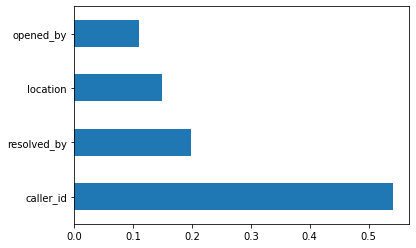

In [37]:
importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [38]:
regressor.score(X_test, Y_test)

0.9060753046844235

In [77]:
y_pred = regressor.predict(X_test)

In [78]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':y_pred})
df

,Actual,Predicted
0,11302.0,11302.0
1,217843.0,217843.0
2,12992.0,12992.0
3,8327.0,8327.0
4,7219.0,7254.0
...,...,...
28338,-1.0,-1.0
28339,34778.0,34778.0
28340,18706.0,18706.0
28341,73410.0,73410.0


In [41]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 7811.102308371954
Mean Squared Error: 1014753607.3400526
Root Mean Squared Error: 31855.19749334561


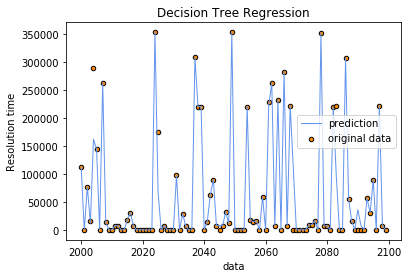

In [42]:

import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2000:2100], Y_test[2000:2100], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2000:2100], y_pred[2000:2100], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 6. Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor



#randomForestRegressor = RandomForestRegressor(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=110, bootstrap=False, random_state=100)
randomForestRegressor = RandomForestRegressor()
randomForestRegressor.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

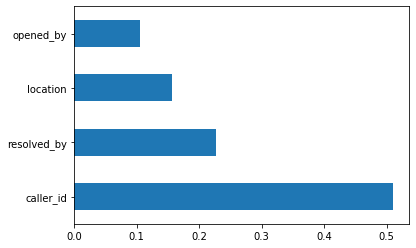

In [44]:
importances = pd.Series(randomForestRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [45]:
randomForestRegressor.score(X_test, Y_test)

0.8998355385798329

In [46]:
yRFR = randomForestRegressor.predict(X_test)

In [47]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yRFR})
df

,Actual,Predicted
0,11302.0,11465.83
1,217843.0,217843.00
2,12992.0,12992.00
3,8327.0,10227.31
4,7219.0,11562.82
...,...,...
28338,-1.0,-1.00
28339,34778.0,34778.00
28340,18706.0,18706.00
28341,73410.0,73410.00


In [48]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, yRFR))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, yRFR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, yRFR)))

Mean Absolute Error: 11175.484742251518
Mean Squared Error: 1082167455.6609573
Root Mean Squared Error: 32896.31370930423


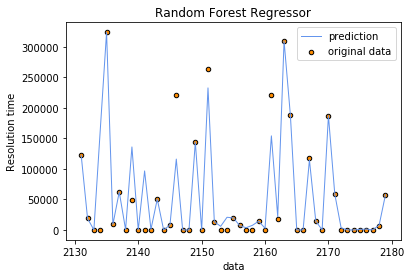

In [49]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yRFR[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Random Forest Regressor")
plt.legend()
plt.show()

### 7. Support Vector Regression

SVR Linear (Ne fonctionne pas)

SVR RBF

### 8. AdaBoost Regressor with decision tree

In [50]:
from sklearn.ensemble import AdaBoostRegressor

adaBoostRegressor = AdaBoostRegressor(n_estimators=150,random_state=0)
#adaBoostRegressor = AdaBoostRegressor()
adaBoostRegressor.fit(X_train,Y_train)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=150, random_state=0)

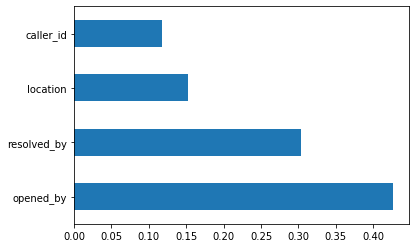

In [51]:
importances = pd.Series(adaBoostRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [52]:
adaBoostRegressor.score(X_test, Y_test)

-0.31000740909954283

In [53]:
yAda = adaBoostRegressor.predict(X_test)

In [54]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yAda})
df

,Actual,Predicted
0,11302.0,139608.930117
1,217843.0,139608.930117
2,12992.0,119039.337542
3,8327.0,119635.020331
4,7219.0,119039.337542
...,...,...
28338,-1.0,139035.030045
28339,34778.0,111501.970346
28340,18706.0,139608.930117
28341,73410.0,119039.337542


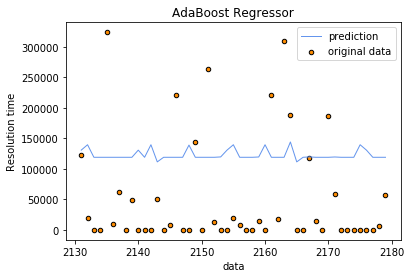

In [55]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yAda[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("AdaBoost Regressor")
plt.legend()
plt.show()

### 9. GradientBoost Regressor

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoostRegressor = GradientBoostingRegressor(random_state=1, n_estimators=150)
#gradientBoostRegressor = GradientBoostingRegressor()
gradientBoostRegressor.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

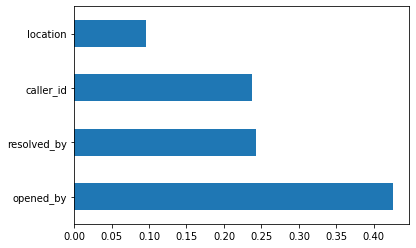

In [57]:
importances = pd.Series(gradientBoostRegressor.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [58]:
gradientBoostRegressor.score(X_test, Y_test)

0.062349999652518966

In [59]:
yGrad = gradientBoostRegressor.predict(X_test)

In [60]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':yGrad})
df

,Actual,Predicted
0,11302.0,76623.967049
1,217843.0,77111.903208
2,12992.0,63609.178252
3,8327.0,95174.923574
4,7219.0,60678.183194
...,...,...
28338,-1.0,77238.584207
28339,34778.0,76085.549978
28340,18706.0,40533.246650
28341,73410.0,64019.210394


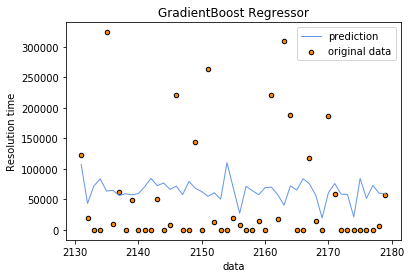

In [61]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], yGrad[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("GradientBoost Regressor")
plt.legend()
plt.show()

### 10. Linear Regressor

In [62]:
from sklearn.linear_model import LinearRegression

linearRegressor = LinearRegression()
linearRegressor.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

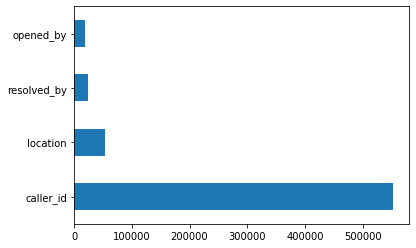

In [63]:
importances = pd.Series(linearRegressor.singular_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')

In [64]:
linearRegressor.score(X_test, Y_test)

0.0006997972068403246

In [65]:
linGrad = linearRegressor.predict(X_test)

In [66]:
df=pd.DataFrame({'Actual':Y_test, 'Predicted':linGrad})
df

,Actual,Predicted
0,11302.0,69449.323703
1,217843.0,71969.904886
2,12992.0,61607.148425
3,8327.0,69477.425250
4,7219.0,63336.472775
...,...,...
28338,-1.0,63988.609112
28339,34778.0,65904.576277
28340,18706.0,67112.854678
28341,73410.0,62144.941097


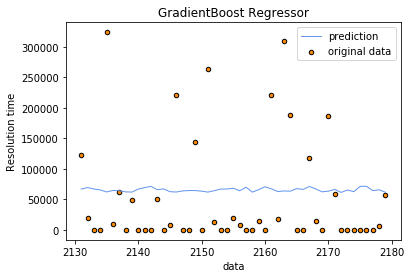

In [67]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2180], Y_test[2131:2180], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2180], linGrad[2131:2180], color="cornflowerblue",
         label="prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("GradientBoost Regressor")
plt.legend()
plt.show()

# III. Résultats finaux

### 1. Comparaison des différents modèles

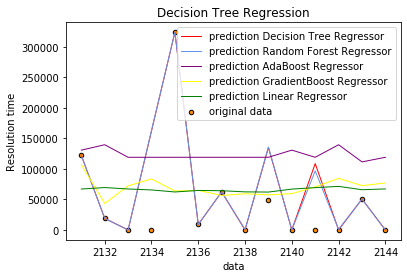

In [68]:
import matplotlib.pyplot as plt 

plt.figure()
plt.scatter(X_test.index[2131:2145], Y_test[2131:2145], s=20, edgecolor="black",
            c="darkorange", label="original data")
plt.plot(X_test.index[2131:2145], y_pred[2131:2145], color="red",
         label="prediction Decision Tree Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yRFR[2131:2145], color="cornflowerblue",
         label="prediction Random Forest Regressor", linewidth=1)
#plt.plot(X_test.index[2131:2145], yRBF[2131:2145], color="green",
#         label="prediction RBF Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yAda[2131:2145], color="purple",
         label="prediction AdaBoost Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], yGrad[2131:2145], color="yellow",
         label="prediction GradientBoost Regressor", linewidth=1)
plt.plot(X_test.index[2131:2145], linGrad[2131:2145], color="green",
         label="prediction Linear Regressor", linewidth=1)
plt.xlabel("data")
plt.ylabel("Resolution time")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Sur ce graphe assez réduit, DecisionTreeRegressor et RandomForestRegressor ont les résultats les plus proches de la réalité.

Comparons les scores:

In [69]:
print("Decision Tree Regressor: ", regressor.score(X_test, Y_test))
print("Random Forest Regressor: ", randomForestRegressor.score(X_test, Y_test))
#print("RBF Regressor: ", rbfRegressor.score(X_test, Y_test))
print("AdaBoost Regressor: ", adaBoostRegressor.score(X_test, Y_test))
print("GradientBoost Regressor: ", gradientBoostRegressor.score(X_test, Y_test))
print("Linear Regressor: ", linearRegressor.score(X_test, Y_test))

Decision Tree Regressor:  0.9060753046844235
Random Forest Regressor:  0.8998355385798329
AdaBoost Regressor:  -0.31000740909954283
GradientBoost Regressor:  0.062349999652518966
Linear Regressor:  0.0006997972068403246


Ces résultats viennent confirmer le ressenti du graphe: Les scores les plus élevés sont Random Forest et Decision Tree.

# IV. Liaison API